# Model Evaluation for BISINDO Sign Language Dataset
This notebook documents the evaluation workflow for the trained BISINDO sign language recognition model. Below is a detailed explanation of each step:

## Importing Required Libraries
We start by importing necessary libraries for model evaluation, visualization, and analysis. These include TensorFlow for loading the model, scikit-learn for metrics calculation, and visualization libraries.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import itertools

## Defining Paths
We define paths for accessing the processed data, landmark files, and trained models to maintain consistent organization across our project.

In [28]:
PROCESSED_PATH = '../data/processed'
LANDMARKS_PATH = os.path.join(PROCESSED_PATH, 'landmarks')
MODELS_PATH = '../models'

## Loading the Model
We attempt to load the best model saved during training, with a fallback to the final model if the best model is not available. This ensures we evaluate the most effective version of our trained model.

In [29]:
try:
    model = load_model(os.path.join(MODELS_PATH, 'best_model.h5'))
    print("Loaded best model from training")
except:
    # If best_model doesn't exist, try to load the final model
    model = load_model(os.path.join(MODELS_PATH, 'final_model.h5'))
    print("Loaded final model")

Loaded best model from training


## Loading Class Names
We load the class name mappings that were saved during training, which allow us to convert between numeric class indices and human-readable sign language labels.

In [30]:
class_names = np.load(os.path.join(MODELS_PATH, 'classes.npy'), allow_pickle=True)
print(f"Loaded {len(class_names)} classes")

Loaded 6 classes


## Loading Metadata
We load the metadata that was created during preprocessing, which contains information about our dataset samples, including their classes and file locations.

In [31]:
metadata_path = os.path.join(PROCESSED_PATH, 'metadata.csv')
df = pd.read_csv(metadata_path)

## Setting Up Label Encoder
We initialize a LabelEncoder and fit it with our loaded class names to ensure consistent encoding between training and evaluation phases.

In [32]:
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

LabelEncoder()

## Encoding Classes
We encode the class labels in our metadata to numeric values using the label encoder, making them compatible with the model's output format.

In [33]:
df['class_encoded'] = label_encoder.transform(df['class'])

## Data Loading Function
We define a function to load and preprocess landmark data, ensuring consistency with the preprocessing applied during training. This function handles various data shapes, normalization, and sequence length adjustments.

In [34]:
def load_data(dataframe, max_frames=100, num_landmarks=33, num_dimensions=3):
    """
    Load and preprocess landmark data from files referenced in the dataframe.
    
    Args:
        dataframe: Pandas DataFrame containing metadata about the samples
        max_frames: Maximum number of frames to keep (for padding/truncating)
        num_landmarks: Number of landmarks in each frame
        num_dimensions: Number of dimensions for each landmark (usually 3 for x,y,z)
        
    Returns:
        X: Array of landmark features
        y: Array of class labels
    """
    X = []
    y = []
    sample_ids = []
    
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading evaluation data"):
        try:
            # Load landmarks data
            landmarks = np.load(row['landmark_path'])
            
            # Handle different possible data shapes
            if landmarks.ndim == 1:
                # If data is flat, attempt to reshape
                landmarks = landmarks.reshape(1, -1)
            
            # Ensure landmarks have consistent dimensions
            if landmarks.shape[1] != num_landmarks * num_dimensions:
                # If dimensions don't match, reshape or skip
                if landmarks.shape[1] % num_dimensions == 0:
                    new_num_landmarks = landmarks.shape[1] // num_dimensions
                    landmarks = landmarks.reshape(landmarks.shape[0], new_num_landmarks, num_dimensions)
                else:
                    print(f"Skipping sample with incompatible shape: {landmarks.shape}")
                    continue
            else:
                # Reshape to (frames, landmarks, dimensions)
                landmarks = landmarks.reshape(landmarks.shape[0], num_landmarks, num_dimensions)
            
            # Normalize coordinates to [0, 1] range
            for i in range(num_dimensions):
                min_val = np.min(landmarks[:, :, i])
                max_val = np.max(landmarks[:, :, i])
                if max_val > min_val:
                    landmarks[:, :, i] = (landmarks[:, :, i] - min_val) / (max_val - min_val)
            
            # Handle sequence length (padding or truncating)
            if landmarks.shape[0] > max_frames:
                # Truncate if too long
                landmarks = landmarks[:max_frames]
            elif landmarks.shape[0] < max_frames:
                # Pad with zeros if too short
                padding = np.zeros((max_frames - landmarks.shape[0], landmarks.shape[1], landmarks.shape[2]))
                landmarks = np.vstack([landmarks, padding])
            
            # Reshape to the format expected by the model
            landmarks = landmarks.reshape(max_frames, -1)  # Flatten landmarks and dimensions
            
            X.append(landmarks)
            y.append(row['class_encoded'])
            sample_ids.append(row['sample_id'])
            
        except Exception as e:
            print(f"Error processing {row['landmark_path']}: {e}")
    
    return np.array(X), np.array(y), sample_ids

## Setting Landmark Parameters
We define the parameters for processing landmark data, matching the values used during training to ensure consistent data representation.

In [35]:
MAX_FRAMES = 100
NUM_LANDMARKS = 33
NUM_DIMENSIONS = 3

## Preparing Test Data
We sample a portion of our dataset to use for evaluation, ensuring we have a representative set of examples to test our model's performance.

In [36]:
test_df = df.sample(frac=0.2, random_state=42)  # 20% of the data for testing
print(f"Using {len(test_df)} samples for evaluation")

Using 3600 samples for evaluation


## Loading Test Data
We load and preprocess the test data using our defined function, preparing it for model evaluation while also tracking sample IDs for detailed analysis.

In [37]:
X_test, y_test, sample_ids = load_data(test_df, max_frames=MAX_FRAMES, 
                                    num_landmarks=NUM_LANDMARKS, 
                                    num_dimensions=NUM_DIMENSIONS)

Loading evaluation data: 100%|██████████| 3600/3600 [00:12<00:00, 295.28it/s]


## Overall Model Evaluation
We evaluate the model's overall performance on the test set, calculating accuracy and loss metrics to gauge general effectiveness.

In [38]:
print("\n--- Overall Model Evaluation ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


--- Overall Model Evaluation ---


2025-05-11 20:23:14.842281: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181440000 exceeds 10% of free system memory.


113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9902 - loss: 0.0367
Test accuracy: 0.9908
Test loss: 0.0342


## Making Predictions
We use the model to make predictions on the test data, obtaining both probability distributions and final class predictions for each sample.

In [39]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

2025-05-11 20:23:28.708408: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181440000 exceeds 10% of free system memory.


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step


## Confusion Matrix Function
We define a function to plot confusion matrices with options for normalization, providing a visual tool to analyze the model's prediction patterns.

In [40]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Function to print and plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating Confusion Matrix
We generate and visualize a standard confusion matrix to see the distribution of predictions compared to true labels across all classes.

Confusion matrix, without normalization


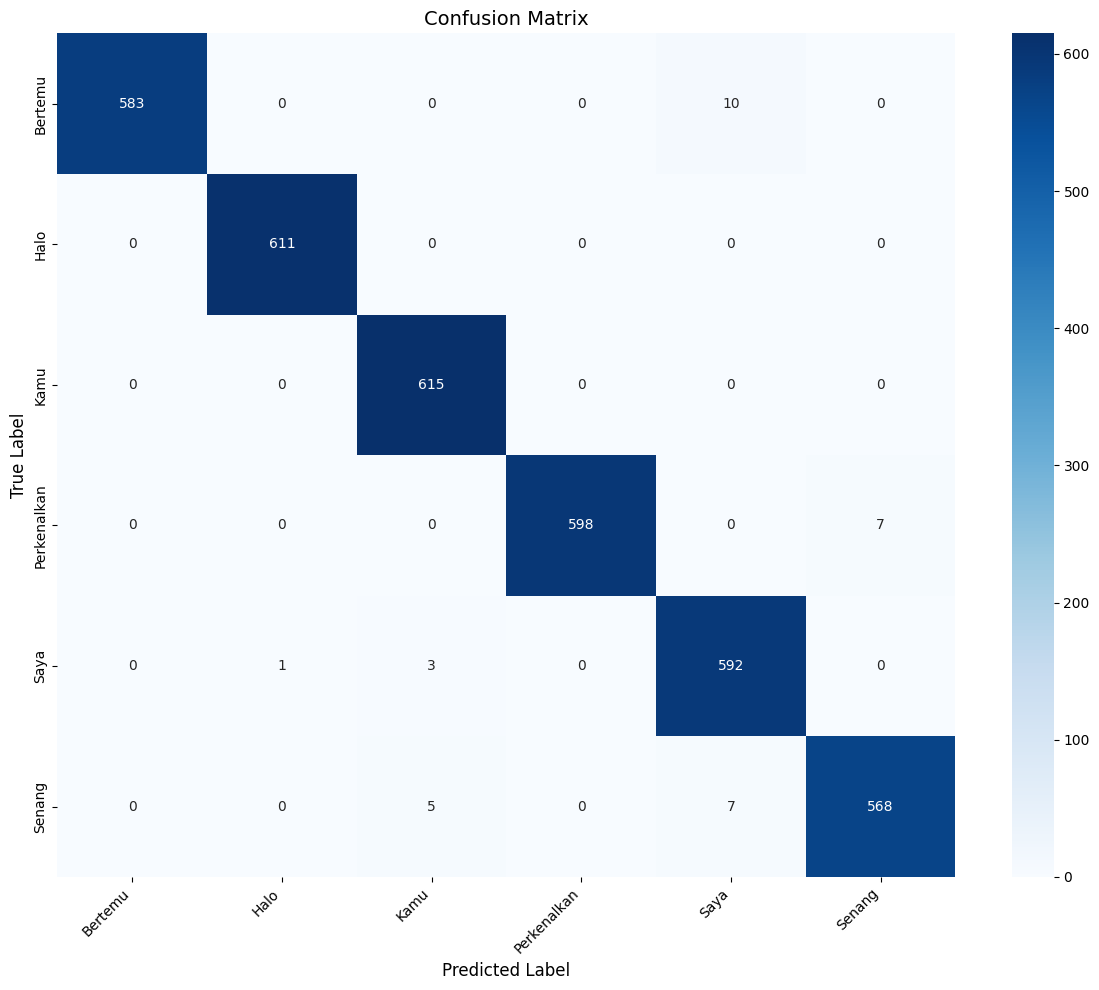

In [41]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

Normalized confusion matrix


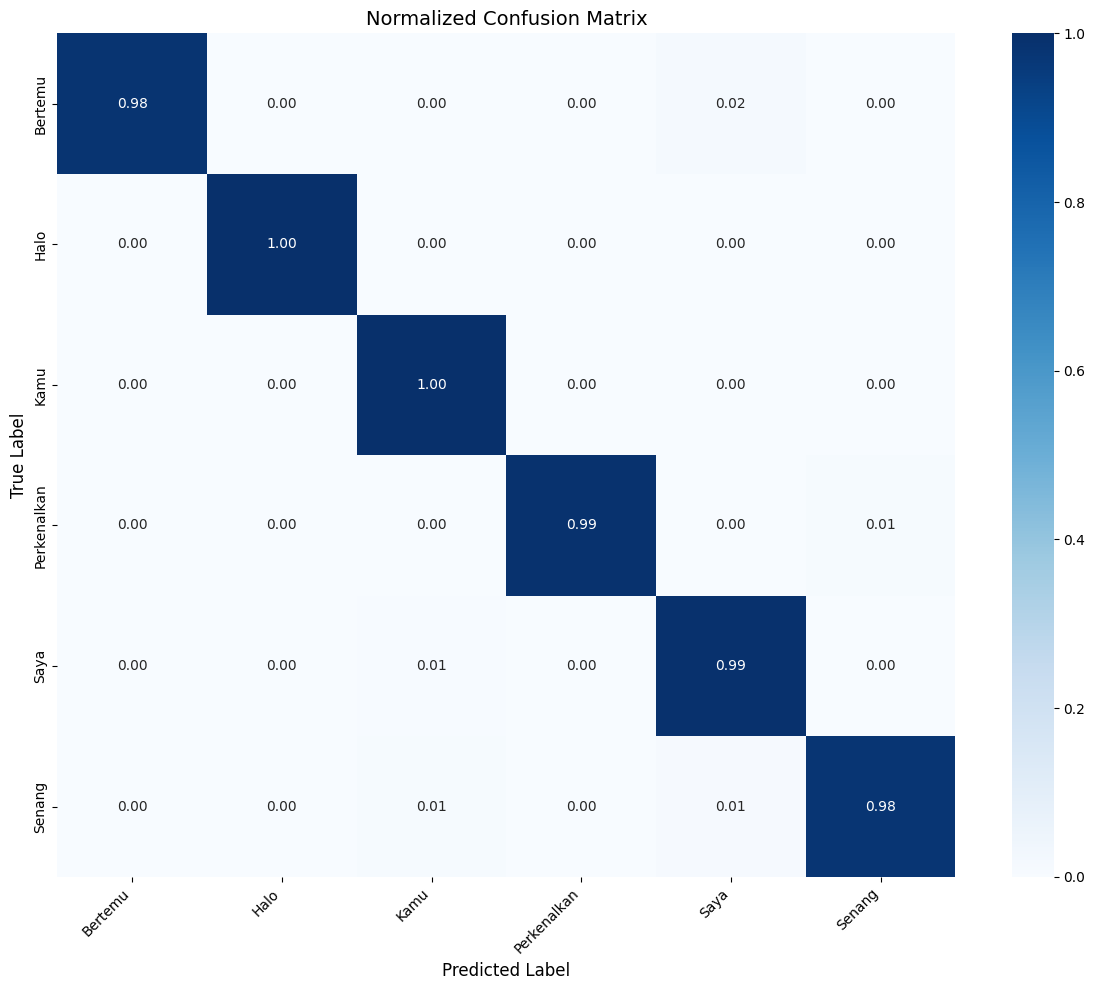

In [42]:
plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized Confusion Matrix')

## Classification Report
We generate a detailed classification report showing precision, recall, and F1 score for each class, providing a comprehensive view of model performance.

In [43]:
print("\n--- Classification Report ---")
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

     Bertemu       1.00      0.98      0.99       593
        Halo       1.00      1.00      1.00       611
        Kamu       0.99      1.00      0.99       615
 Perkenalkan       1.00      0.99      0.99       605
        Saya       0.97      0.99      0.98       596
      Senang       0.99      0.98      0.98       580

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



## Per-Class Performance Metrics
We extract detailed performance metrics for each class to analyze how the model performs across different sign language gestures.

In [44]:
print("\n--- Per-Class Performance Metrics ---")
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)


--- Per-Class Performance Metrics ---


## Organizing Performance Data
We organize the per-class performance metrics into a DataFrame for easier analysis and visualization.

In [45]:
class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})
print(class_metrics.sort_values('F1 Score'))

         Class  Precision    Recall  F1 Score  Support
4         Saya   0.972085  0.993289  0.982573      596
5       Senang   0.987826  0.979310  0.983550      580
0      Bertemu   1.000000  0.983137  0.991497      593
2         Kamu   0.987159  1.000000  0.993538      615
3  Perkenalkan   1.000000  0.988430  0.994181      605
1         Halo   0.998366  1.000000  0.999182      611


## Visualizing Class Performance
We create a bar chart showing precision, recall, and F1 score for each class, sorted by F1 score to highlight strengths and weaknesses.

<Figure size 1400x700 with 0 Axes>

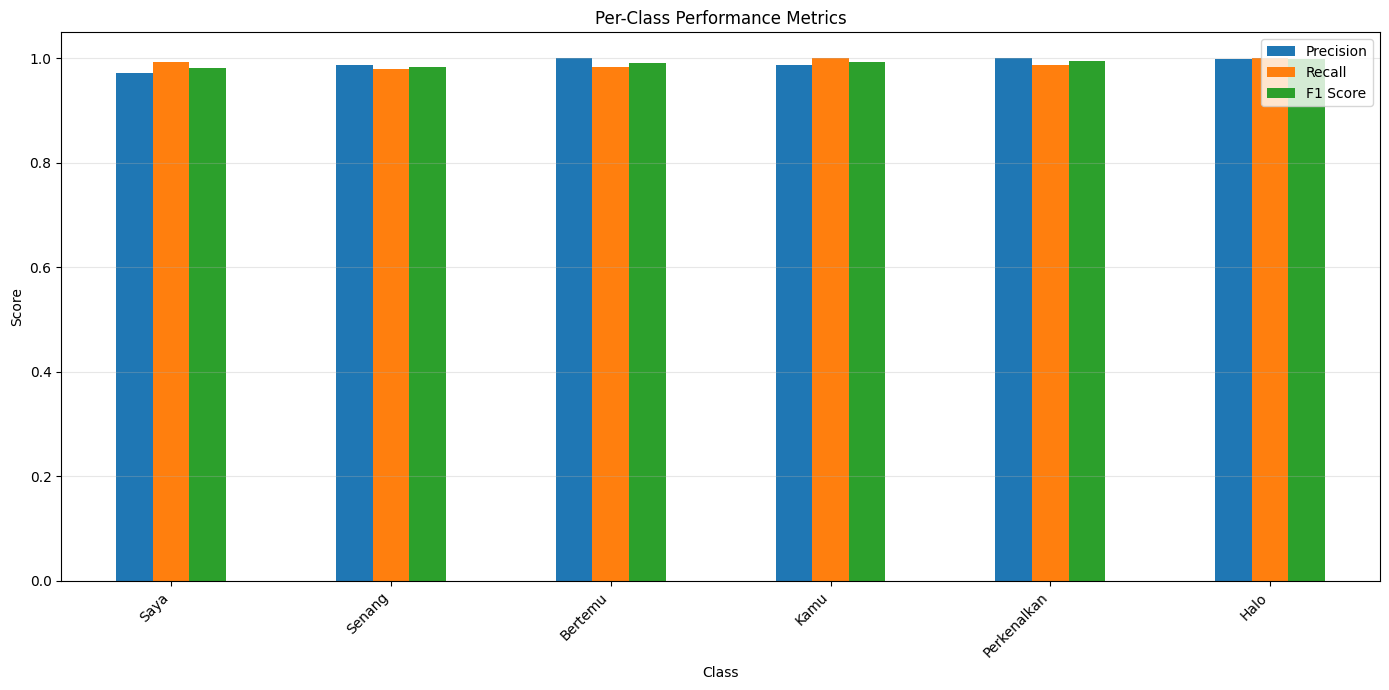

In [46]:
plt.figure(figsize=(14, 7))
class_metrics.sort_values('F1 Score').plot(x='Class', y=['Precision', 'Recall', 'F1 Score'], 
                                          kind='bar', figsize=(14, 7))
plt.title('Per-Class Performance Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Identifying Misclassifications
We identify and count the samples that were misclassified by the model to understand the overall error rate.

In [47]:
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"\n--- Analysis of Misclassified Samples ---")
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(y_test)} " 
      f"({len(misclassified_indices)/len(y_test)*100:.2f}%)")


--- Analysis of Misclassified Samples ---
Total misclassified samples: 33 out of 3600 (0.92%)


## Analyzing Misclassified Samples
We perform detailed analysis of misclassified samples, extracting information about the true class, predicted class, and model confidence for each error. We also specifically examine errors made with high confidence, as these are cases where the model is confidently wrong and may require special attention.

In [48]:
if len(misclassified_indices) > 0:
    misclassified_data = []
    for idx in misclassified_indices:
        true_class = class_names[y_test[idx]]
        pred_class = class_names[y_pred[idx]]
        confidence = y_pred_prob[idx][y_pred[idx]]
        sample_id = sample_ids[idx]
        
        misclassified_data.append({
            'Sample ID': sample_id,
            'True Class': true_class,
            'Predicted Class': pred_class,
            'Confidence': confidence
        })
    
    misclassified_df = pd.DataFrame(misclassified_data)
    
    # Show common confusions
    confusion_pairs = misclassified_df.groupby(['True Class', 'Predicted Class']).size().reset_index(name='Count')
    confusion_pairs = confusion_pairs.sort_values('Count', ascending=False)
    
    print("\nTop confused class pairs:")
    print(confusion_pairs.head(10))
    
    # High confidence mistakes are particularly interesting
    high_conf_mistakes = misclassified_df[misclassified_df['Confidence'] > 0.8].sort_values('Confidence', ascending=False)
    
    if len(high_conf_mistakes) > 0:
        print("\nHigh confidence mistakes:")
        print(high_conf_mistakes.head(10))
    else:
        print("\nNo high confidence mistakes found.")


Top confused class pairs:
    True Class Predicted Class  Count
0      Bertemu            Saya     10
1  Perkenalkan          Senang      7
5       Senang            Saya      7
4       Senang            Kamu      5
3         Saya            Kamu      3
2         Saya            Halo      1

High confidence mistakes:
        Sample ID True Class Predicted Class  Confidence
15      Saya_1_13       Saya            Halo    0.998851
28  Bertemu_72_24    Bertemu            Saya    0.979294
2   Bertemu_45_29    Bertemu            Saya    0.978942
26  Bertemu_45_17    Bertemu            Saya    0.978675
0   Bertemu_72_16    Bertemu            Saya    0.978483
8   Bertemu_45_15    Bertemu            Saya    0.978313
19  Bertemu_72_21    Bertemu            Saya    0.978191
4    Senang_15_17     Senang            Saya    0.977928
7     Senang_8_21     Senang            Saya    0.976117
6    Bertemu_45_8    Bertemu            Saya    0.975277


## Visualizing Confidence Distribution
We create a histogram showing the distribution of confidence scores for both correct and incorrect predictions, helping us understand if the model's confidence is calibrated to its accuracy.

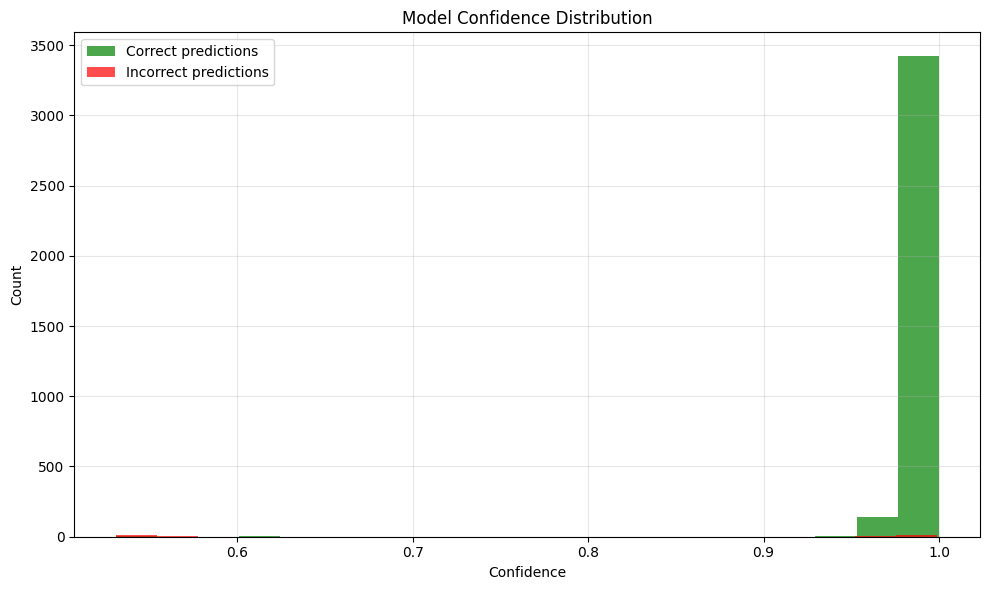

In [49]:
plt.figure(figsize=(10, 6))
confidence_correct = [max(prob) for prob, pred, true in zip(y_pred_prob, y_pred, y_test) if pred == true]
confidence_incorrect = [max(prob) for prob, pred, true in zip(y_pred_prob, y_pred, y_test) if pred != true]

plt.hist(confidence_correct, alpha=0.7, label='Correct predictions', bins=20, color='green')
plt.hist(confidence_incorrect, alpha=0.7, label='Incorrect predictions', bins=20, color='red')
plt.title('Model Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Confidence-Correctness Correlation
We calculate the correlation between model confidence and prediction correctness, providing a metric for how well the model's confidence scores reflect its actual performance

# Data Preprocessing and Visualization for BISINDO Sign Language Dataset

This notebook documents the preprocessing and visualization workflow for the BISINDO sign language dataset. Below is a detailed explanation of each step:

In [50]:
all_confidences = [max(prob) for prob in y_pred_prob]
correctness = [1 if pred == true else 0 for pred, true in zip(y_pred, y_test)]
correlation = np.corrcoef(all_confidences, correctness)[0, 1]
print(f"\nCorrelation between model confidence and correctness: {correlation:.4f}")


Correlation between model confidence and correctness: 0.6268


## Class Distribution in Test Dataset
We visualize the distribution of classes in our test dataset to ensure we have a balanced evaluation and to understand any potential biases in our results.

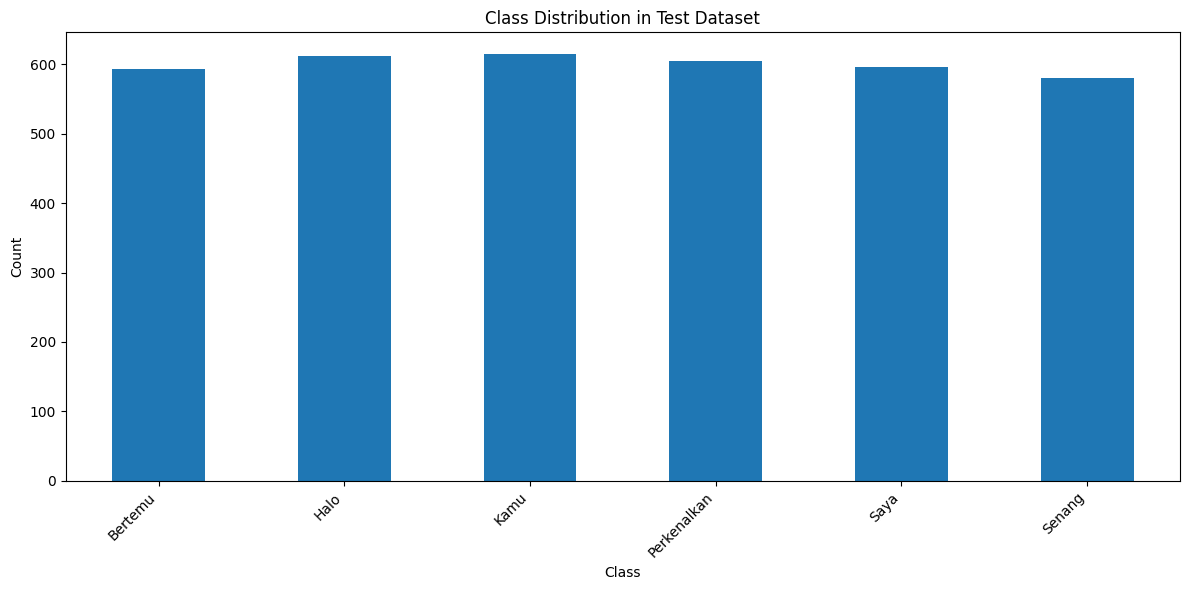


Evaluation completed successfully!


In [51]:
plt.figure(figsize=(12, 6))
pd.Series(y_test).map(lambda x: class_names[x]).value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Test Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nEvaluation completed successfully!")